# Label Selection

This is a **manual workflow**. Once a dataset has been populated with the results from the **Ensemble Exploration** workflow, this workflow can be used to select the samples to be labeled. Here you manually select the final images to be labeled. These will be exported and are ready to be labeled.


In [25]:
# Connect to CVAT
import os
with open("../.secret", "r") as file:
    for line in file:
        key, value = line.strip().split("=")
        if key in ["FIFTYONE_CVAT_USERNAME", "FIFTYONE_CVAT_PASSWORD", "FIFTYONE_CVAT_EMAIL"]:
            print(key)
            os.environ[key] = value

FIFTYONE_CVAT_USERNAME
FIFTYONE_CVAT_PASSWORD
FIFTYONE_CVAT_EMAIL


In [26]:
from fiftyone import ViewField as F
import fiftyone as fo

In [27]:
# Loading dataset and filtering view for optimized performance
# Shows only samples with min. n unique detections from Ensemble Exploration
# Shows only labels that belong to the unique detections
dataset_name = "mcity_fisheye_3_months" # Dataset to load
dataset = fo.load_dataset(dataset_name)
min_n_unique_exploration = 3
view_n_unique_exploration = dataset.match(F("n_unique_exploration") >= min_n_unique_exploration)
view_tagged_labels = view_n_unique_exploration.select_labels(tags="vru_overlap")    # FIXME detections_overlap


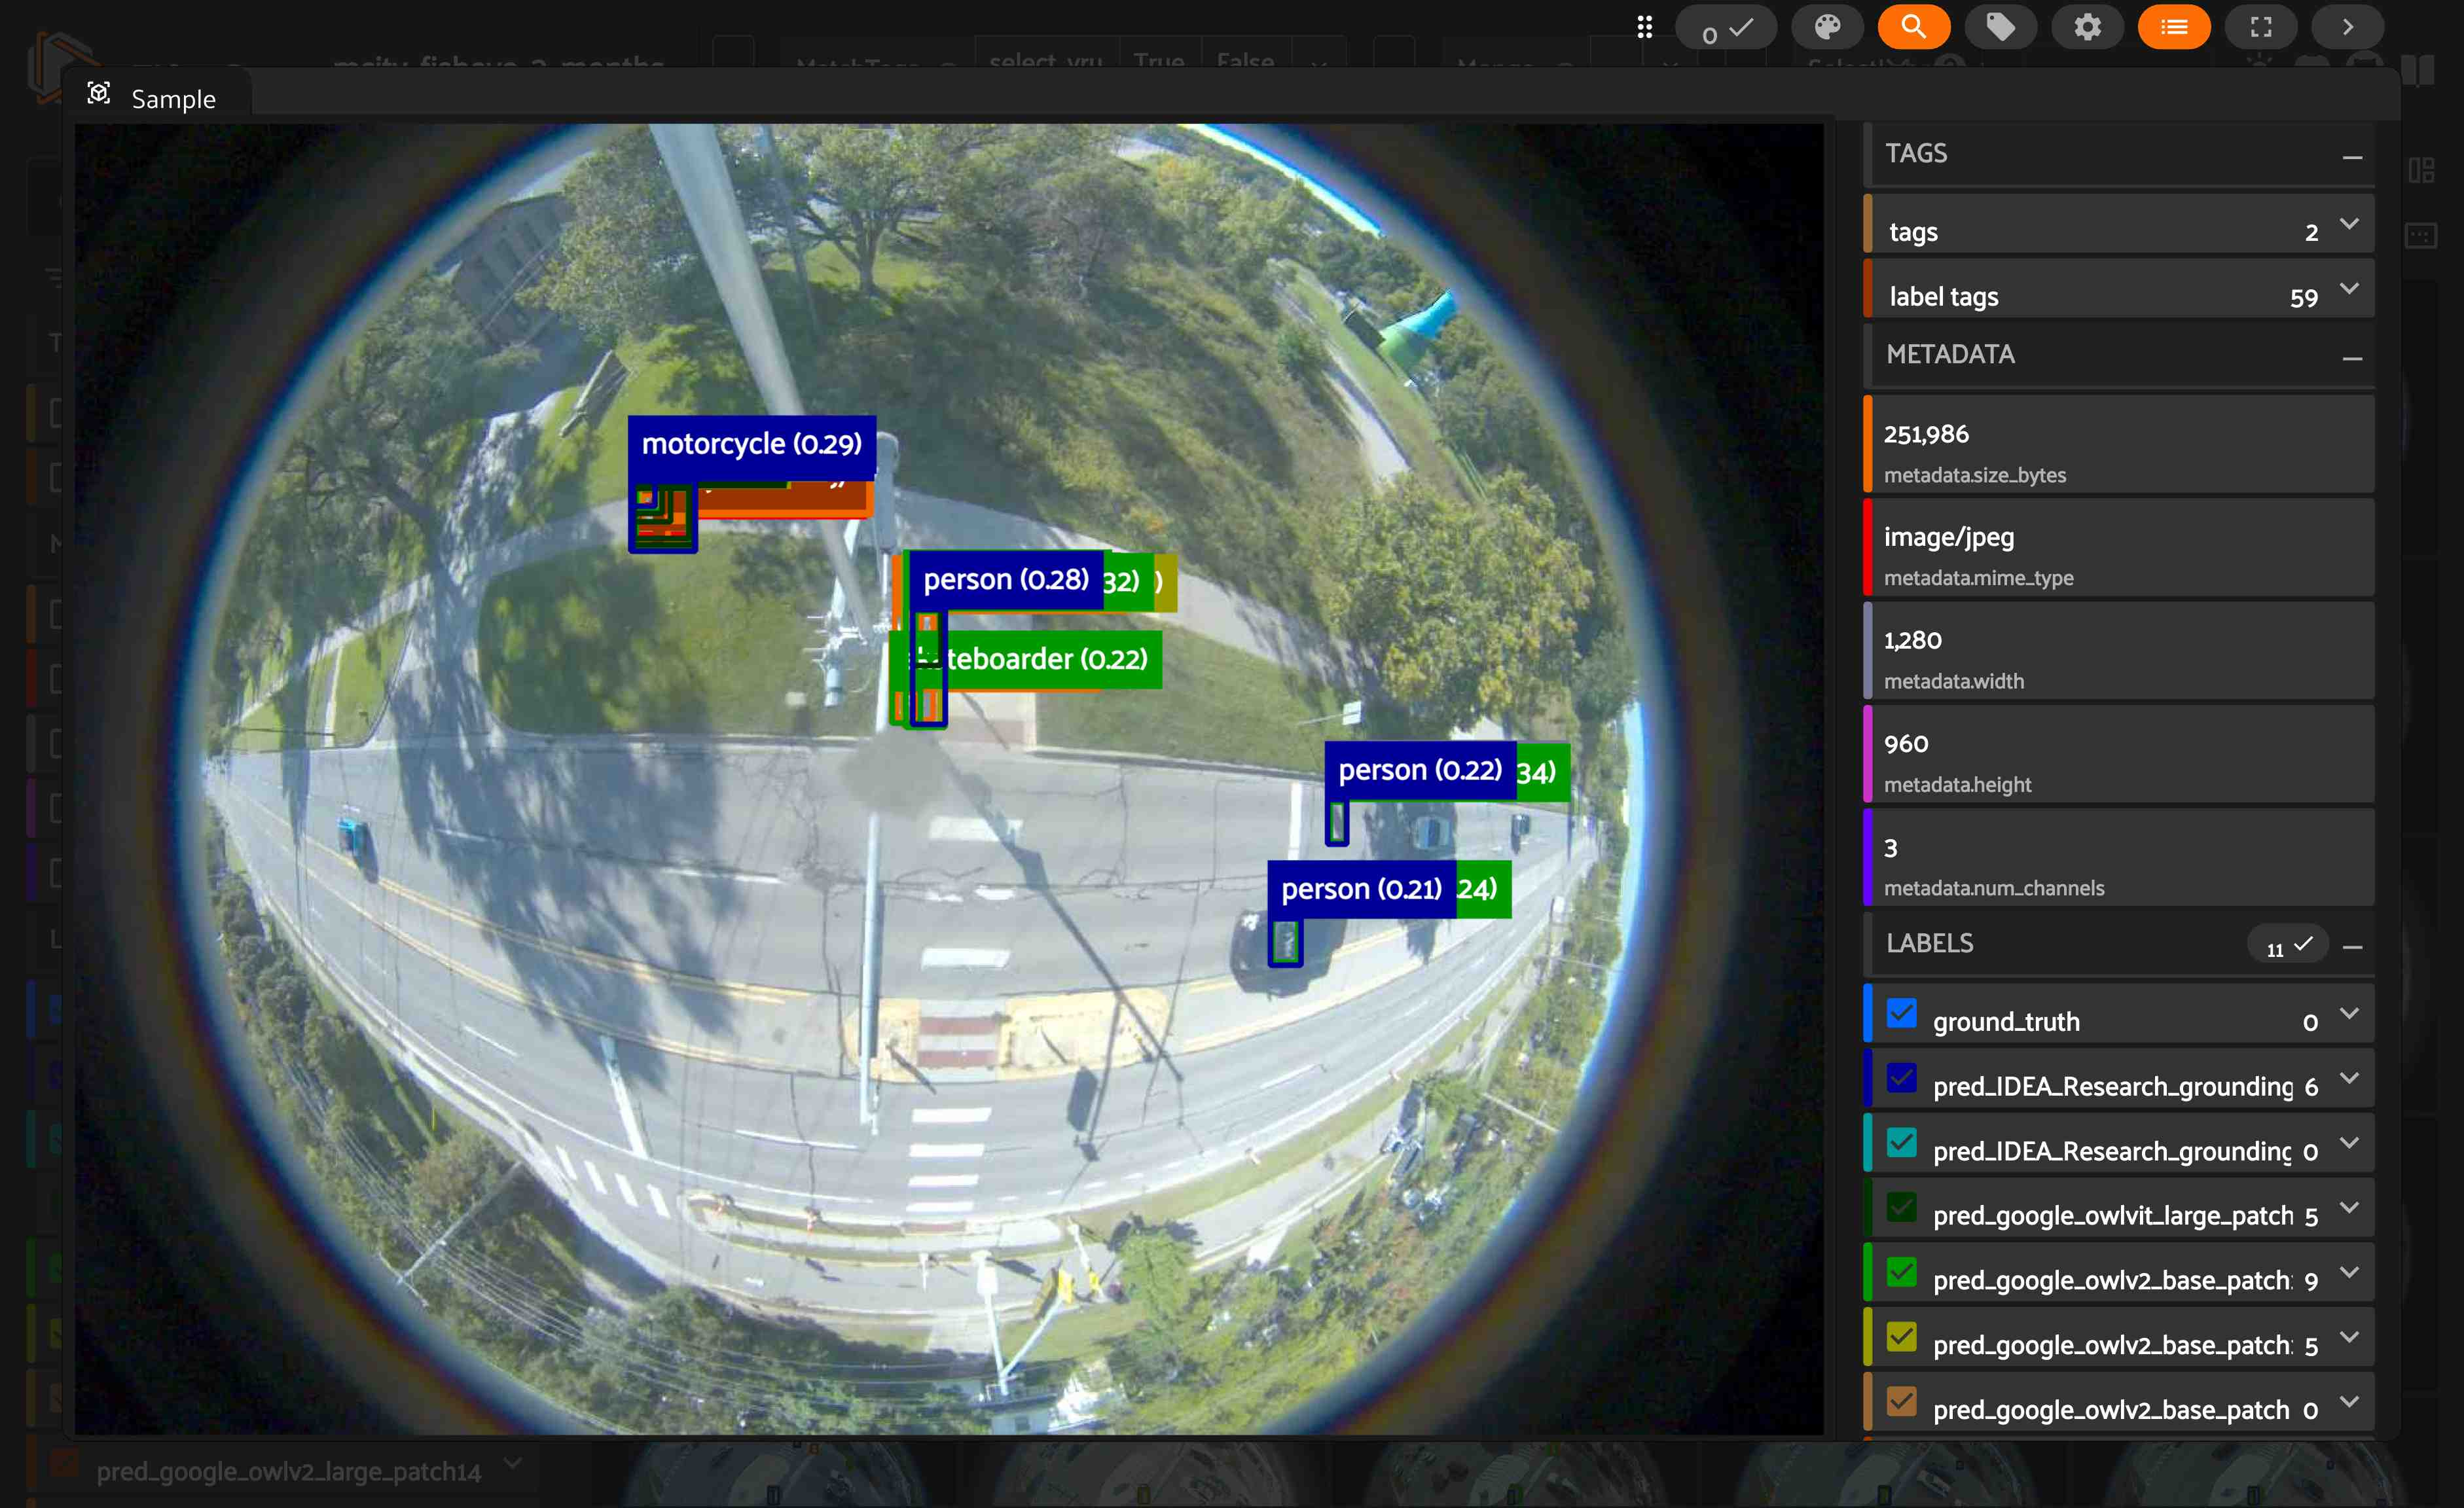

Dataset:          mcity_fisheye_3_months
Media type:       image
Num samples:      10653
Selected samples: 0
Selected labels:  0
Session URL:      http://localhost:5151/
View stages:
    1. Match(filter={'$expr': {'$gte': [...]}})
    2. SelectLabels(labels=None, ids=None, tags=['vru_overlap'], fields=None, omit_empty=True)

In [28]:
# Use this view to label the samples you want to have labeled
# Choose the tag_for_labeling to tag the samples you want to label
tag_for_labeling = "select_vru" # FIXME todo_label
fo.launch_app(view=view_tagged_labels)

In [29]:
# Inspect your selection of samples to be labeled
view_selection = dataset.match_tags(tag_for_labeling)
print(view_selection)

Dataset:     mcity_fisheye_3_months
Media type:  image
Num samples: 100
Sample fields:
    id:                                           fiftyone.core.fields.ObjectIdField
    filepath:                                     fiftyone.core.fields.StringField
    tags:                                         fiftyone.core.fields.ListField(fiftyone.core.fields.StringField)
    metadata:                                     fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.metadata.ImageMetadata)
    created_at:                                   fiftyone.core.fields.DateTimeField
    last_modified_at:                             fiftyone.core.fields.DateTimeField
    ground_truth:                                 fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Detections)
    location:                                     fiftyone.core.fields.StringField
    name:                                         fiftyone.core.fields.StringField
    timestamp:                       

In [30]:
# Export the dataset you want to have labeled
# This example uses the YOLOv5Dataset format which also exports labels
# https://docs.voxel51.com/user_guide/export_datasets.html#yolov5dataset

splits = ["train", "val"]                                                   # Select all the splits your dataset has
export_dir="/media/dbogdoll/Datasets/vru_labeling"                          # Directory to export the files to
label_field="pred_google_owlv2_large_patch14_finetuned"                     # Include a prediction field from one of the zero-shot models

classes=view_selection.distinct(f"{label_field}.detections.label")          # Get all the classes from the prediction field

# Export the splits
for split in splits:
    split_view = view_selection.match_tags(split)
    split_view.export(
        export_dir=export_dir,
        dataset_type=fo.types.YOLOv5Dataset,
        label_field=label_field,
        split=split,
        classes=classes,
    )

Directory '/media/dbogdoll/Datasets/vru_labeling' already exists; export will be merged with existing files
 100% |███████████████████| 96/96 [5.5s elapsed, 0s remaining, 25.1 samples/s]      
Directory '/media/dbogdoll/Datasets/vru_labeling' already exists; export will be merged with existing files
 100% |█████████████████████| 4/4 [113.4ms elapsed, 0s remaining, 35.3 samples/s] 


In [ ]:
# If you want to label the dataset in-house, this example shows how to use CVAT. Voxel51 also has other integrations
# You will only need a CVAT account and set the environment variables at the top of the notebook
# https://docs.voxel51.com/integrations/cvat.html

classes_for_labeling = ["motorbike/cycler", "pedestrian"]    # ["car", "truck", "bus", "trailer", "motorbike/cycler", "pedestrian", "van", "pickup"] Classes from Mcity Fisheye dataset
label_schema = {
    "new_ground_truth": {
        "type": "polylines",
        "classes": classes_for_labeling,
    },
}

anno_key = "cvat"
if view_selection.has_annotation_runs:
    view_selection.delete_annotation_run(anno_key)

view_selection.annotate(
    anno_key,
    backend="cvat",
    label_schema=label_schema,
    launch_editor=True,
)

Uploading samples to CVAT...
Launching editor at 'https://app.cvat.ai/tasks/1087235/jobs/1866110'...


In [ ]:
# Once you have annotated the dataset, you can import the labels back into FiftyOne
dataset.load_annotations(anno_key)
view_annotations = dataset.load_annotation_view(anno_key)
fo.launch_app(view=view_annotations)

Download complete
Loading labels for field 'new_ground_truth'...
 100% |█████████████████| 100/100 [105.8ms elapsed, 0s remaining, 945.4 samples/s]    


Dataset:          mcity_fisheye_3_months
Media type:       image
Num samples:      100
Selected samples: 0
Selected labels:  0
Session URL:      http://localhost:5151/
View stages:
    1. MatchTags(tags=['select_vru'], bool=True, all=False)

In [ ]:
# Cleanup

# Delete tasks from CVAT
#results = dataset.load_annotation_results(anno_key)
#results.cleanup()

# Delete run record (not the labels) from FiftyOne
#dataset.delete_annotation_run(anno_key)